In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy as np

import matplotlib.pyplot as plt

import os
from glob import glob

In [3]:
file_path = '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/*.tfrec'
filenames = glob(file_path)
filenames

['/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train00.tfrec',
 '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train01.tfrec',
 '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train02.tfrec',
 '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train03.tfrec',
 '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train04.tfrec',
 '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train05.tfrec',
 '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train06.tfrec',
 '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train07.tfrec',
 '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train08.tfrec',
 '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train09.tfrec',
 '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train10.tfrec',
 '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train11.tfrec',
 '/content/drive/MyDrive/innerwave/Triplet Loss tfrecords/train12.tfrec',
 '/content/drive/MyDrive/innerwave/Tri

In [4]:
# 데이터 종류 확인
train_dataset = tf.data.TFRecordDataset(filenames)
for raw_record in train_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "anchor_img"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\002\001\001\002\002\002\002\002\002\002\002\003\005\003\003\003\003\003\006\004\004\003\005\007\006\007\007\007\006\007\007\010\t\013\t\010\010\n\010\007\007\n\r\n\n\013\014\014\014\014\007\t\016\017\r\014\016\013\014\014\014\377\333\000C\001\002\002\002\003\003\003\006\003\003\006\014\010\007\010\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\377\300\000\021\010\000\200\000\200\003\001\"\000\002\021\001\003\021\001\377\304\000\036\000\000\001\004\003\001\001\001\000\000\000\000\000\000\000\000\000\006\003\005\007\010\002\004\t\001\000\n\377\304\0005\020\000\002\002\002\001\002\005\003\003\003\003\004\003\001\000\000\001\002\003\004\005\021\022\006!\000\0

In [5]:
data_description = {
    'anchor_img': tf.io.FixedLenFeature([], tf.string),
    'positive_img': tf.io.FixedLenFeature([], tf.string),
    'negative_img': tf.io.FixedLenFeature([], tf.string)
}

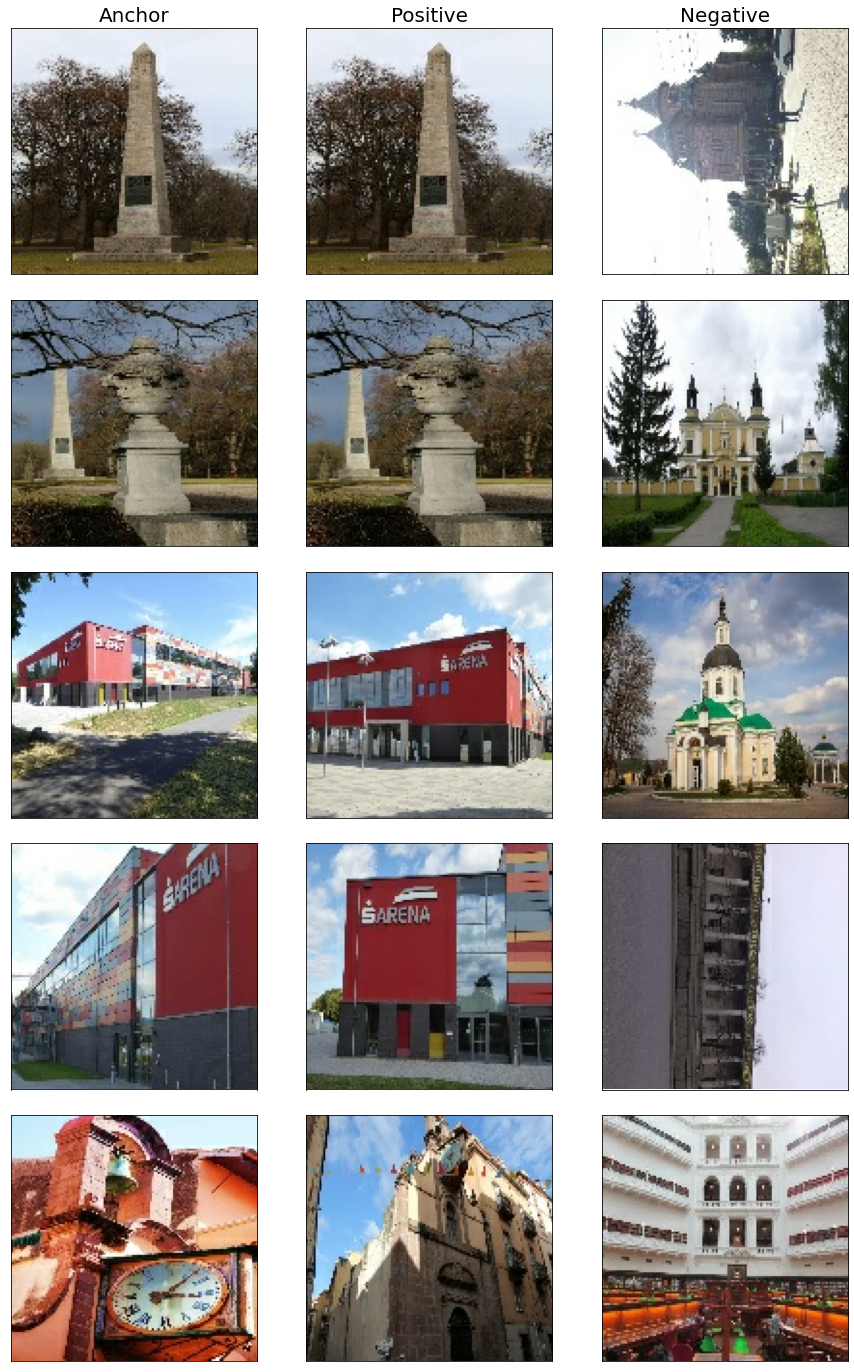

In [6]:
fig, axes = plt.subplots(5,3, figsize=(15, 25))

# tick 제거
for ax in axes.flat:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# title
axes[0, 0].set_title('Anchor', fontsize=20)
axes[0, 1].set_title('Positive', fontsize=20)
axes[0, 2].set_title('Negative', fontsize=20)




# 데이터 5개 불러오기

for idx, raw_record in enumerate(train_dataset.take(5)):
    
    parsed_data = tf.io.parse_single_example(raw_record, data_description)
    anchor = tf.image.decode_image(parsed_data['anchor_img'])
    anchor = tf.image.convert_image_dtype(anchor, tf.float32).numpy()
    positive = tf.image.decode_image(parsed_data['positive_img'])
    positive = tf.image.convert_image_dtype(positive, tf.float32).numpy()
    negative = tf.image.decode_image(parsed_data['negative_img'])
    negative = tf.image.convert_image_dtype(negative, tf.float32).numpy()

    axes[idx, 0].imshow(anchor)
    axes[idx, 1].imshow(positive)
    axes[idx, 2].imshow(negative)
    
# 간격조정
fig.subplots_adjust(hspace=0)

In [7]:
# 데이터셋 만들기

def get_triplet(example):
    data_description = {
    'anchor_img': tf.io.FixedLenFeature([], tf.string),
    'positive_img': tf.io.FixedLenFeature([], tf.string),
    'negative_img': tf.io.FixedLenFeature([], tf.string)
    }
    
    parsed_data = tf.io.parse_single_example(example, data_description)
    
    anchor = tf.image.decode_image(parsed_data['anchor_img'])
    anchor = tf.image.convert_image_dtype(anchor, tf.float32)
    positive = tf.image.decode_image(parsed_data['positive_img'])
    positive = tf.image.convert_image_dtype(positive, tf.float32)
    negative = tf.image.decode_image(parsed_data['negative_img'])
    negative = tf.image.convert_image_dtype(negative, tf.float32)
    
    x = {
        'anchor_input': anchor,
        'positive_input': positive,
        'negative_input': negative
    }

    return x, np.array([0], dtype=np.float32)

In [8]:
ds = tf.data.TFRecordDataset(filenames)
train_ds = ds.map(get_triplet, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_ds = train_ds.shuffle(1024)
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
class GeMPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, p=1., eps=1e-6):
        super().__init__()
        self.p = p
        self.eps = eps

    def call(self, inputs: tf.Tensor, **kwargs):
        inputs = tf.clip_by_value(
            inputs, 
            clip_value_min=self.eps, 
            clip_value_max=tf.reduce_max(inputs)
        )
        inputs = tf.pow(inputs, self.p)
        inputs = tf.reduce_mean(inputs, axis=[1, 2], keepdims=False)
        inputs = tf.pow(inputs, 1. / self.p)
        
        return inputs
    
    def get_config(self):
        return {
            'p': self.p,
            'eps': self.eps
        }

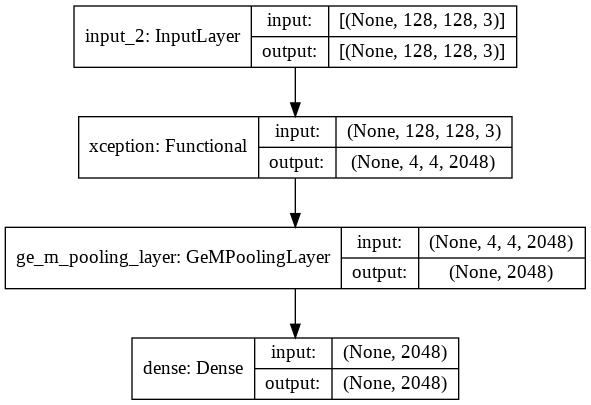

In [10]:
# enbedding_model 구현
image_shape=(128, 128, 3)

backbone = tf.keras.applications.Xception(weights = 'imagenet', include_top=False, input_shape=image_shape)
backbone.trainable = False

input_ = tf.keras.layers.Input(shape=image_shape)
x = backbone(input_)
x = GeMPoolingLayer()(x)
output_ = tf.keras.layers.Dense(2048, activation='softplus', kernel_regularizer=tf.keras.regularizers.l2(), dtype='float32')(x)

embedding_model = tf.keras.models.Model(inputs=input_, outputs=output_, name='embedding')
plot_model(embedding_model, show_shapes=True, show_layer_names=True)

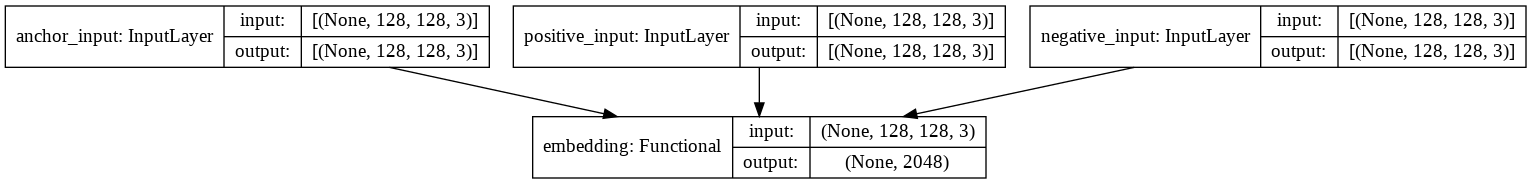

In [11]:
# anchor encoding
anchor_input = tf.keras.Input(shape=image_shape, name='anchor_input')
anchor_x = embedding_model(anchor_input)

# positive encoding
positive_input = tf.keras.Input(shape=image_shape, name='positive_input')
positive_x = embedding_model(positive_input)

# anchor encoding
negative_input = tf.keras.Input(shape=image_shape, name='negative_input')
negative_x = embedding_model(negative_input)

# construct model
model = tf.keras.models.Model(
    inputs=[anchor_input, positive_input, negative_input], 
    outputs=[anchor_x, positive_x, negative_x]
    )
plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
def triplet_loss(y_pred, alpha=0.2):     
    anchors = y_pred[0]
    positives = y_pred[1]
    negatives = y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchors, positives)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchors, negatives)), axis=-1)

    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))

    return loss

In [13]:
model.compile(optimizer='adam', loss=triplet_loss)

In [14]:
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                monitor = 'loss',
                                                verbose=1)

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                factor=0.5,         
                                                patience=2,         
                                                verbose=1)

In [15]:
model.fit(train_ds,
          epochs=20,
          callbacks = [checkpoint, reduceLR]
          )

Epoch 1/20
1271/1271 [==============================] - 672s 498ms/step - loss: 4038.9463 - embedding_loss: 1332.0934 - embedding_1_loss: 1322.7650 - embedding_2_loss: 1326.5126

Epoch 00001: loss improved from inf to 4038.94629, saving model to my_checkpoint.ckpt
Epoch 2/20
1271/1271 [==============================] - 623s 489ms/step - loss: 413.8286 - embedding_loss: 108.9393 - embedding_1_loss: 104.9587 - embedding_2_loss: 108.0640

Epoch 00002: loss improved from 4038.94629 to 413.82855, saving model to my_checkpoint.ckpt
Epoch 3/20
1271/1271 [==============================] - 634s 498ms/step - loss: 278.4866 - embedding_loss: 56.7084 - embedding_1_loss: 53.1798 - embedding_2_loss: 55.7554

Epoch 00003: loss improved from 413.82855 to 278.48663, saving model to my_checkpoint.ckpt
Epoch 4/20
1271/1271 [==============================] - 642s 504ms/step - loss: 232.2060 - embedding_loss: 37.4427 - embedding_1_loss: 34.4282 - embedding_2_loss: 36.5662

Epoch 00004: loss improved from 2

In [19]:
model.load_weights(checkpoint_path)

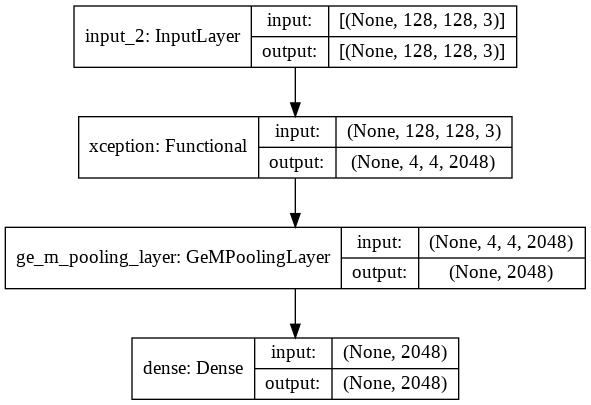

In [20]:
embedding = model.get_layer('embedding')
plot_model(embedding, show_shapes=True, show_layer_names=True)